In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial import distance

import straticor as scr

plt.style.use(
    "https://raw.githubusercontent.com/srnarvaez/my-mpl-themes/main/basic.mplstyle"
)

# %matplotlib widget


In [2]:
col_1 = scr.load_column("../data/afloramiento/quebrada_la_amarilla_1/lam1.xlsx", delta=0.2)
col_1 = col_1.query("bottom > 179 & bottom < 192")
col_1["bottom"] = col_1["bottom"] - col_1["bottom"].min()

col_2 = scr.load_column("../data/afloramiento/quebrada_la_amarilla_2/lam2.xlsx", delta=0.2)
col_2 = col_2.query("bottom < 7.6")

coords_magna_sirgas = {
    "lam1": (5019490.37879000045, 2056395.02013000008),
    "lam2": (5019520.80912999995, 2056369.25162000000),
}

# wgs84
coords = {
    "lam1": (-72.82423434000, 4.51037816000),
    "lam2": (-72.82395998000, 4.51014488000),
}

# web mercator
# coords = {
#     "lam1": (-8106756.6842347793, 502612.3824546233),
#     "lam2": (-8106726.1419516532, 502586.3331930861),
# }

space = distance.euclidean(coords_magna_sirgas["lam1"], coords_magna_sirgas["lam2"])
mercator_space = distance.euclidean(coords["lam1"], coords["lam2"])


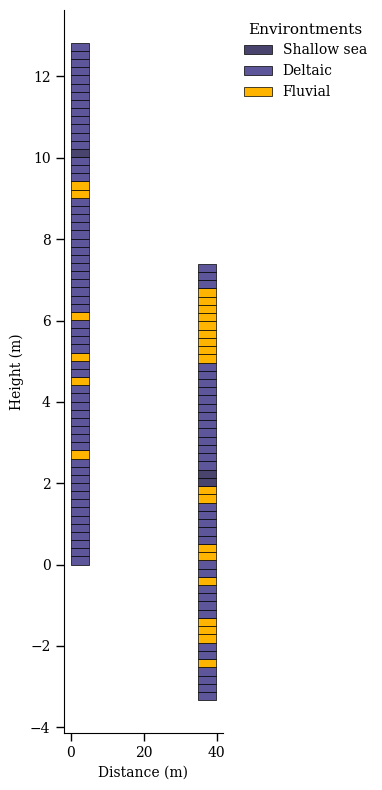

In [3]:
fig, ax = plt.subplots(figsize=(4, 8))

ax = scr.plot_column(col_1, ax=ax, x_pos=0, width=5, lw=0.5)
ax = scr.plot_column(col_2, ax=ax, x_pos=space-5, width=5, lw=0.5)

ax.set(ylabel="Height (m)", xlabel="Distance (m)")

plt.show()


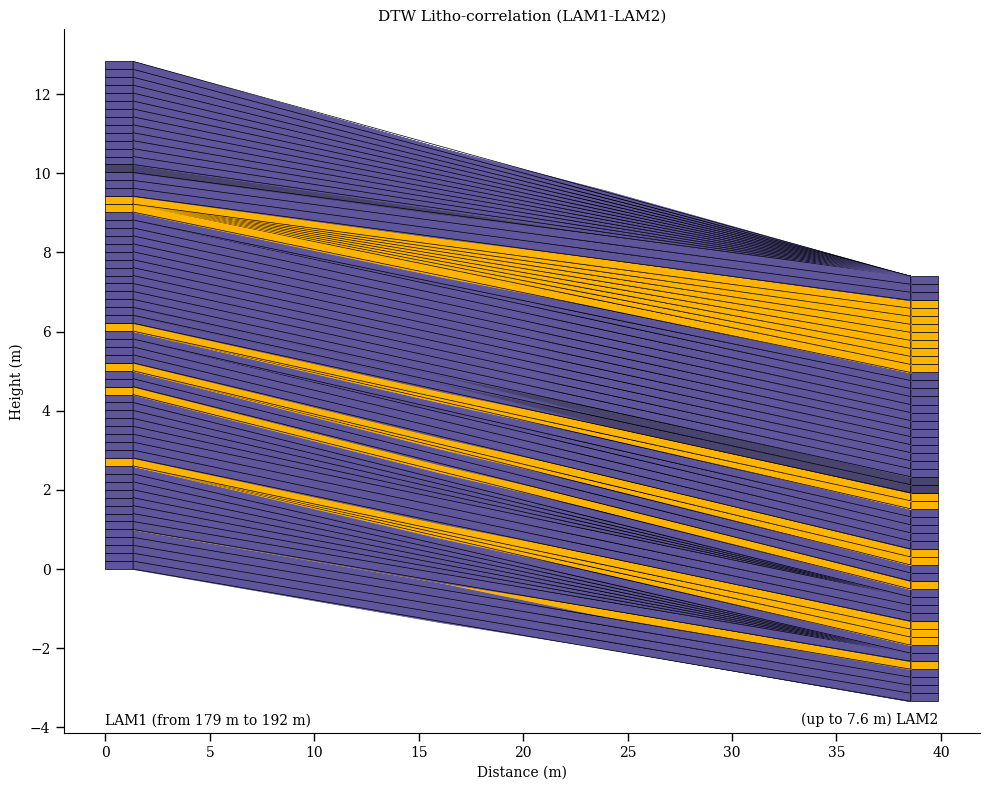

In [4]:
d, corr_matrix = scr.dtw_log(col_1, col_2, cost_func="litho", penalty=0.0)
col_3, corr_path = scr.warp_log(col_1, col_2, corr_matrix)

fig, ax = plt.subplots(figsize=(10, 8))

ax = scr.plot_section(col_1, col_2, corr_path, space=space, ax=ax, lw=0.5, legend=False)
ax.text(0.0, -4.0, "LAM1 (from 179 m to 192 m)", va="bottom", ha="left")
ax.text(space, -4.0, "(up to 7.6 m) LAM2", va="bottom", ha="right")

ax.set(
    xlabel="Distance (m)",
    ylabel="Height (m)",
    title="DTW Litho-correlation (LAM1-LAM2)",
)

plt.show()


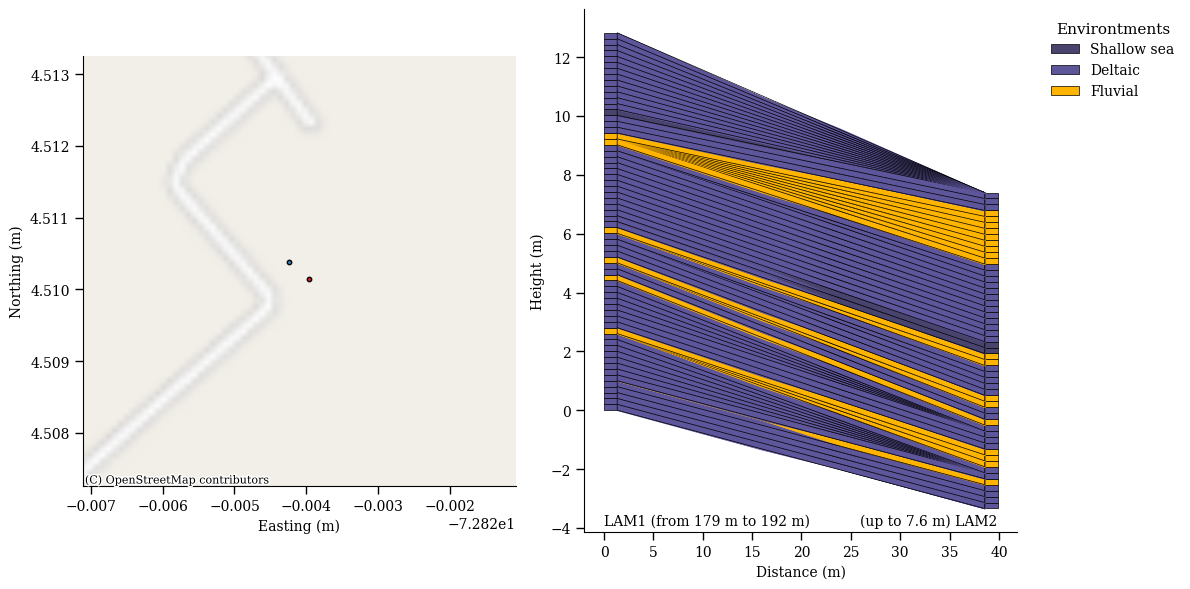

In [5]:
import contextily as ctx


fig, axs = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)

axs[1] = scr.plot_section(col_1, col_2, corr_path, space=space, ax=axs[1], lw=0.5)
axs[1].text(0.0, -4.0, "LAM1 (from 179 m to 192 m)", va="bottom", ha="left")
axs[1].text(space, -4.0, "(up to 7.6 m) LAM2", va="bottom", ha="right")

for name, x_y in coords.items():
    axs[0].scatter(*x_y, s=10, label=name)


ctx.add_basemap(
    axs[0],
    zoom=14,
    source=ctx.providers.OpenStreetMap.Mapnik,
    # source=ctx.providers.Esri.WorldImagery,
    crs="EPSG:4326",
)

N = 8

axs[0].set(
    xlabel="Easting (m)",
    ylabel="Northing (m)",
    xlim=(min(coords["lam1"][0], coords["lam2"][0])-mercator_space*N, max(coords["lam1"][0], coords["lam2"][0])+mercator_space*N),
    ylim=(min(coords["lam1"][1], coords["lam2"][1])-mercator_space*N, max(coords["lam1"][1], coords["lam2"][1])+mercator_space*N),
)
axs[1].set(xlabel="Distance (m)", ylabel="Height (m)")

plt.show()


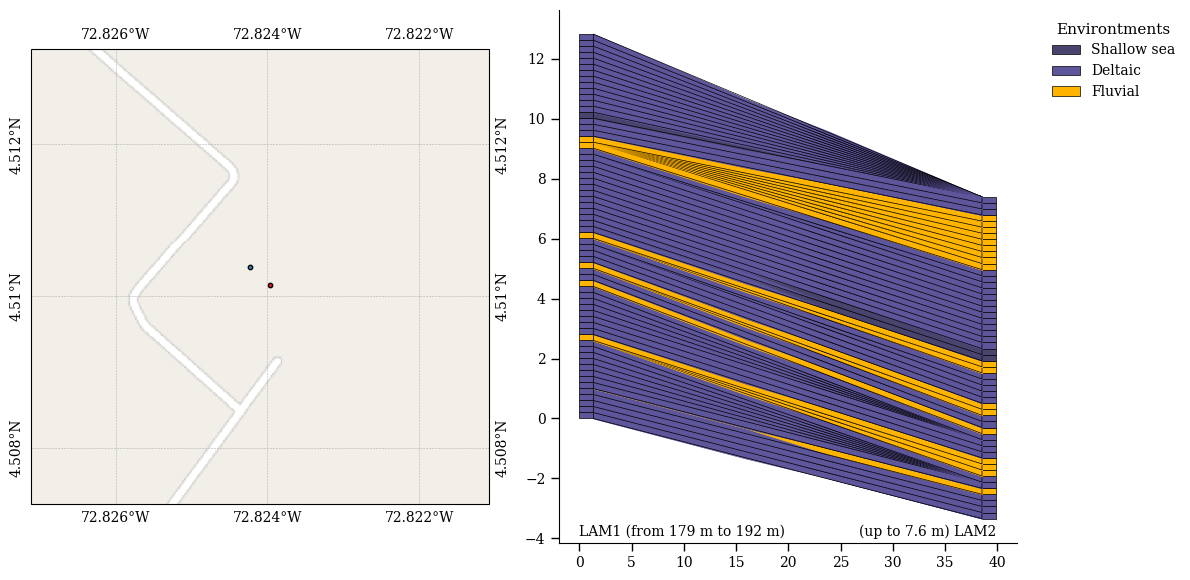

In [6]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker

from cartopy.io.img_tiles import OSM


N = 8

fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([
    min(coords["lam1"][0], coords["lam2"][0])-mercator_space*N,
    max(coords["lam1"][0], coords["lam2"][0])+mercator_space*N,
    min(coords["lam1"][1], coords["lam2"][1])-mercator_space*N,
    max(coords["lam1"][1], coords["lam2"][1])+mercator_space*N,
])

tiler = OSM()

ax1.add_image(tiler, 16)
ax1.add_feature(cfeature.RIVERS, alpha=0.7)
ax1.add_feature(cfeature.LAKES, alpha=0.7)

for name, x_y in coords.items():
    ax1.scatter(*x_y, s=10, label=name)

ax2 = fig.add_subplot(1, 2, 2)
ax2 = scr.plot_section(col_1, col_2, corr_path, space=space, ax=ax2, lw=0.5)
ax2.text(0.0, -4.0, "LAM1 (from 179 m to 192 m)", va="bottom", ha="left")
ax2.text(space, -4.0, "(up to 7.6 m) LAM2", va="bottom", ha="right")

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linestyle="--")

gl.xlocator = mticker.MultipleLocator(base=0.002)
gl.ylocator = mticker.MultipleLocator(base=0.002)
gl.ylabel_style = {"rotation": 90}

plt.show()
